In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [ ]:
!pip install albumentations bayesian-optimization timm -q
!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118
!pip install timm albumentations

In [2]:
import os

# Base Directory
base_dir = 'FaceDetectionViT'

# Folders ki list
folders = [
    'config', 'data', 'models', 'losses', 
    'training', 'evaluation', 'utils', 
    'checkpoints', 'logs'
]

# Folders create karna
for folder in folders:
    os.makedirs(os.path.join(base_dir, folder), exist_ok=True)
    # Empty init file taaki python isko package samjhe
    with open(os.path.join(base_dir, folder, '__init__.py'), 'w') as f:
        pass

print("✅ Folder Structure Created Successfully!")

✅ Folder Structure Created Successfully!


In [10]:
import onnx
import torch

# ONNX load karo
onnx_model = onnx.load("/kaggle/input/ritik2342/FaceModel_Final.onnx")

# But PyTorch me directly load karna mushkil hai
# Kyunki ONNX me optimizer state nahi hota

In [5]:
import os

# Kaggle input folder me kya hai check karo
print("Available datasets:")
for folder in os.listdir('/kaggle/input/'):
    print(f"  - {folder}")
    
    # Uss folder ke andar kya hai
    folder_path = f'/kaggle/input/{folder}'
    if os.path.isdir(folder_path):
        print(f"    Contents: {os.listdir(folder_path)[:5]}")  # First 5 items

Available datasets:
  - rit123
    Contents: ['FaceModel_Weights_30Epoch.pth']
  - webface-112x112
    Contents: ['webface_112x112']


In [4]:
import os
import cv2
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
import albumentations as A
from albumentations.pytorch import ToTensorV2
from torch.cuda.amp import autocast, GradScaler
import numpy as np

# ==============================
# CONFIG - 30 epoch se continue
# ==============================
class Config:
    DATA_ROOT = '/kaggle/input/webface_112x112'
    IMG_SIZE = 112
    EMBEDDING_SIZE = 512
    BATCH_SIZE = 128
    NUM_EPOCHS = 100  # ✅ 30 se 100 tak chalega
    
    # ✅ Lower LR for fine-tuning (56% se improve karne ke liye)
    BACKBONE_LR = 0.0001  # 10x lower than before
    HEAD_LR = 0.01        # 10x lower
    
    DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    # ✅ IMPORTANT: Apni download ki checkpoint file ka path
    CHECKPOINT_PATH = "/kaggle/input/rit123/FaceModel_Weights_30Epoch.pth"
    SAVE_DIR = "/kaggle/working/"
    
    # ✅ Improved settings (architecture same rahega)
    LABEL_SMOOTHING = 0.15  # Increased for better generalization
    MIXUP_ALPHA = 0.3       # MixUp for accuracy boost
    USE_FOCAL_LOSS = False  # Keep False to maintain same training
    GRADIENT_CLIP = 1.0


# ==============================
# EXACT SAME MODEL ARCHITECTURE (NO CHANGES!)
# ==============================
class DualAttention(nn.Module):
    def __init__(self, in_channels):
        super().__init__()
        self.fc = nn.Sequential(
            nn.Linear(in_channels, in_channels // 16, bias=False),
            nn.ReLU(inplace=True),
            nn.Linear(in_channels // 16, in_channels, bias=False),
            nn.Sigmoid()
        )
    def forward(self, x):
        return x * self.fc(x)


class HybridFaceModel(nn.Module):
    """✅ EXACT SAME as your original model"""
    def __init__(self, num_classes):
        super().__init__()

        resnet = models.resnet34(weights='DEFAULT')
        self.resnet_features = nn.Sequential(*list(resnet.children())[:-1])

        encoder_layer = nn.TransformerEncoderLayer(d_model=512, nhead=8, batch_first=True)
        self.vit = nn.TransformerEncoder(encoder_layer, num_layers=4)

        self.patch_embed = nn.Conv2d(3, 512, kernel_size=16, stride=16)
        self.pos_embed = nn.Parameter(torch.randn(1, (112 // 16) ** 2, 512) * 0.02)

        self.resnet_proj = nn.Linear(512, 512)
        self.attention = DualAttention(1024)
        self.fusion = nn.Linear(1024, 512)
        self.embedding = nn.BatchNorm1d(512)

    def forward(self, x):
        r = self.resnet_features(x).flatten(1)
        r_proj = self.resnet_proj(r)

        v = self.patch_embed(x).flatten(2).transpose(1, 2)
        v = self.vit(v + self.pos_embed).mean(dim=1)

        combined = torch.cat([r_proj, v], dim=1)
        combined = self.attention(combined)
        return self.embedding(self.fusion(combined))


class ArcFaceLoss(nn.Module):
    """✅ EXACT SAME as your original ArcFace"""
    def __init__(self, in_features, out_features):
        super().__init__()
        self.weight = nn.Parameter(torch.FloatTensor(out_features, in_features))
        nn.init.xavier_uniform_(self.weight)

    def forward(self, embeddings, labels):
        cosine = F.linear(F.normalize(embeddings), F.normalize(self.weight))
        theta = torch.acos(cosine.clamp(-1, 1))
        output = torch.cos(theta + 0.4)

        one_hot = torch.zeros_like(cosine)
        one_hot.scatter_(1, labels.view(-1, 1).long(), 1)

        return ((one_hot * output) + ((1.0 - one_hot) * cosine)) * 30.0


# ==============================
# IMPROVED AUGMENTATION (for accuracy boost)
# ==============================
def get_improved_transforms():
    """🔥 Better augmentations while keeping training stable"""
    return A.Compose([
        A.HorizontalFlip(p=0.5),
        A.ShiftScaleRotate(
            shift_limit=0.1, 
            scale_limit=0.15, 
            rotate_limit=10, 
            p=0.4
        ),
        A.OneOf([
            A.GaussNoise(var_limit=(5, 30), p=1.0),
            A.GaussianBlur(blur_limit=3, p=1.0),
        ], p=0.2),
        A.RandomBrightnessContrast(
            brightness_limit=0.2, 
            contrast_limit=0.2, 
            p=0.3
        ),
        A.CoarseDropout(
            max_holes=4, 
            max_height=12, 
            max_width=12, 
            p=0.2
        ),
        A.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
        ToTensorV2()
    ])


# ==============================
# MIXUP (for better accuracy)
# ==============================
def mixup_data(x, y, alpha=0.3):
    if alpha > 0:
        lam = np.random.beta(alpha, alpha)
    else:
        lam = 1
    
    batch_size = x.size()[0]
    index = torch.randperm(batch_size).to(x.device)
    
    mixed_x = lam * x + (1 - lam) * x[index, :]
    y_a, y_b = y, y[index]
    return mixed_x, y_a, y_b, lam


def mixup_criterion(criterion, pred, y_a, y_b, lam):
    return lam * criterion(pred, y_a) + (1 - lam) * criterion(pred, y_b)


# ==============================
# DATASET
# ==============================
class FaceDataset(Dataset):
    def __init__(self, paths, labels, transform=None):
        self.paths = paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.paths)

    def __getitem__(self, idx):
        img = cv2.imread(self.paths[idx])
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        if self.transform:
            img = self.transform(image=img)['image']

        return img, self.labels[idx]


# ==============================
# 🚀 RESUME TRAINING FROM EPOCH 30
# ==============================
print("="*60)
print("🔥 RESUMING TRAINING FROM YOUR 30-EPOCH CHECKPOINT")
print("="*60)
print(f"📊 Current Accuracy: 56%")
print(f"🎯 Target Accuracy: 90%+")
print(f"📈 Training: Epoch 30 → 100")
print("="*60)

# Load dataset
if not os.path.exists(Config.DATA_ROOT):
    raise SystemExit(f"❌ Dataset not found: {Config.DATA_ROOT}")

image_paths, labels = [], []
label_dirs = sorted([p for p in os.listdir(Config.DATA_ROOT) 
                    if os.path.isdir(os.path.join(Config.DATA_ROOT, p))])
label_to_idx = {p: i for i, p in enumerate(label_dirs)}

for p in label_to_idx.keys():
    p_path = os.path.join(Config.DATA_ROOT, p)
    for img_name in os.listdir(p_path):
        if img_name.lower().endswith(('.jpg', '.jpeg', '.png')):
            image_paths.append(os.path.join(p_path, img_name))
            labels.append(label_to_idx[p])

print(f"✅ Total Images: {len(image_paths)}")
print(f"✅ Total Classes: {len(label_to_idx)}")

# Dataset with improved augmentation
dataset = FaceDataset(image_paths, labels, get_improved_transforms())
loader = DataLoader(
    dataset, 
    batch_size=Config.BATCH_SIZE, 
    shuffle=True, 
    num_workers=4, 
    pin_memory=True,
    drop_last=True
)

# ✅ Initialize model (SAME ARCHITECTURE)
model = HybridFaceModel(len(label_to_idx)).to(Config.DEVICE)
arcface = ArcFaceLoss(512, len(label_to_idx)).to(Config.DEVICE)

# Optimizer with LOWER learning rate for fine-tuning
optimizer = torch.optim.SGD([
    {'params': model.resnet_features.parameters(), 'lr': Config.BACKBONE_LR},
    {'params': [p for n, p in model.named_parameters() if "resnet_features" not in n], 
     'lr': Config.HEAD_LR},
    {'params': arcface.parameters(), 'lr': Config.HEAD_LR}
], momentum=0.9, weight_decay=1e-4)

scaler = GradScaler()
criterion = nn.CrossEntropyLoss(label_smoothing=Config.LABEL_SMOOTHING)

# ✅ Cosine Annealing LR Scheduler (for gradual LR decrease)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
    optimizer, 
    T_max=Config.NUM_EPOCHS - 30,  # 30 se 100 tak
    eta_min=1e-6
)

# ✅✅✅ LOAD YOUR 30-EPOCH CHECKPOINT
start_epoch = 30  # Default
best_acc = 56.0

if os.path.exists(Config.CHECKPOINT_PATH):
    print(f"\n🔄 Loading your trained checkpoint...")
    ckpt = torch.load(Config.CHECKPOINT_PATH, map_location=Config.DEVICE)
    
    # Load all states
    model.load_state_dict(ckpt["model_state"])
    arcface.load_state_dict(ckpt["arcface_state"])
    optimizer.load_state_dict(ckpt["optimizer_state"])
    scaler.load_state_dict(ckpt["scaler_state"])
    
    start_epoch = ckpt.get("epoch", 30)
    
    print(f"✅ Successfully loaded checkpoint!")
    print(f"✅ Starting from epoch: {start_epoch}")
    print(f"✅ Previous accuracy: {best_acc}%")
    print(f"✅ Will train till epoch: {Config.NUM_EPOCHS}")
    
    # Update optimizer LR to new values
    for param_group in optimizer.param_groups:
        param_group['lr'] *= 0.1  # 10x lower for fine-tuning
    
    print(f"✅ Learning rates updated for fine-tuning")
    print(f"   - Backbone LR: {optimizer.param_groups[0]['lr']:.6f}")
    print(f"   - Head LR: {optimizer.param_groups[1]['lr']:.6f}")
else:
    print(f"❌ Checkpoint not found at: {Config.CHECKPOINT_PATH}")
    print("⚠️  Will train from scratch (not recommended!)")
    input("Press Enter to continue or Ctrl+C to stop...")

print("\n" + "="*60)
print("🚀 STARTING TRAINING...")
print("="*60 + "\n")

# ==============================
# TRAINING LOOP: Epoch 30 → 100
# ==============================
for epoch in range(start_epoch, Config.NUM_EPOCHS):
    model.train()
    running_loss, correct, total = 0.0, 0, 0
    
    pbar = tqdm(loader, desc=f"Epoch {epoch+1}/{Config.NUM_EPOCHS}")
    
    for img, label in pbar:
        img, label = img.to(Config.DEVICE), label.to(Config.DEVICE)
        
        # ✅ MixUp augmentation (30% chance)
        use_mixup = Config.MIXUP_ALPHA > 0 and np.random.rand() < 0.3
        
        if use_mixup:
            img, label_a, label_b, lam = mixup_data(img, label, Config.MIXUP_ALPHA)
            
            optimizer.zero_grad()
            with autocast():
                emb = model(img)
                out = arcface(emb, label_a)
                loss = mixup_criterion(criterion, out, label_a, label_b, lam)
        else:
            optimizer.zero_grad()
            with autocast():
                emb = model(img)
                out = arcface(emb, label)
                loss = criterion(out, label)
        
        scaler.scale(loss).backward()
        
        # ✅ Gradient clipping (prevents exploding gradients)
        scaler.unscale_(optimizer)
        torch.nn.utils.clip_grad_norm_(model.parameters(), Config.GRADIENT_CLIP)
        
        scaler.step(optimizer)
        scaler.update()
        
        running_loss += loss.item()
        _, pred = out.max(1)
        total += label.size(0)
        correct += pred.eq(label).sum().item()
        
        pbar.set_postfix({
            "Loss": f"{loss.item():.4f}",
            "Acc": f"{100.0*correct/total:.2f}%",
            "Best": f"{best_acc:.2f}%"
        })
    
    # Update learning rate
    scheduler.step()
    
    epoch_acc = 100.0 * correct / total
    avg_loss = running_loss / len(loader)
    
    print(f"\n{'='*60}")
    print(f"📊 EPOCH {epoch+1}/{Config.NUM_EPOCHS} SUMMARY")
    print(f"{'='*60}")
    print(f"🔹 Train Accuracy: {epoch_acc:.2f}%")
    print(f"🔹 Avg Loss: {avg_loss:.4f}")
    print(f"🔹 Backbone LR: {optimizer.param_groups[0]['lr']:.7f}")
    print(f"🔹 Head LR: {optimizer.param_groups[1]['lr']:.6f}")
    print(f"🔹 Best So Far: {best_acc:.2f}%")
    
    # ✅ Save if accuracy improved
    if epoch_acc > best_acc:
        improvement = epoch_acc - best_acc
        best_acc = epoch_acc
        
        best_path = os.path.join(Config.SAVE_DIR, "best_model.pth")
        torch.save({
            "epoch": epoch + 1,
            "model_state": model.state_dict(),
            "arcface_state": arcface.state_dict(),
            "optimizer_state": optimizer.state_dict(),
            "scaler_state": scaler.state_dict(),
            "accuracy": best_acc,
            "loss": avg_loss
        }, best_path)
        
        print(f"🎉 NEW BEST! Improved by {improvement:.2f}%")
        print(f"💾 Saved: {best_path}")
    
    # ✅ Regular checkpoint every 10 epochs
    if (epoch + 1) % 10 == 0:
        checkpoint_name = f"checkpoint_epoch_{epoch+1}_acc_{epoch_acc:.1f}.pth"
        checkpoint_path = os.path.join(Config.SAVE_DIR, checkpoint_name)
        
        torch.save({
            "epoch": epoch + 1,
            "model_state": model.state_dict(),
            "arcface_state": arcface.state_dict(),
            "optimizer_state": optimizer.state_dict(),
            "scaler_state": scaler.state_dict(),
            "accuracy": epoch_acc,
            "loss": avg_loss
        }, checkpoint_path)
        
        print(f"💾 Checkpoint saved: {checkpoint_name}")
    
    print(f"{'='*60}\n")

# ==============================
# FINAL ONNX EXPORT
# ==============================
print("\n" + "="*60)
print("📦 Exporting final model to ONNX...")
print("="*60)

model.eval()
dummy = torch.randn(1, 3, 112, 112).to(Config.DEVICE)

onnx_filename = f"FaceModel_Epoch{Config.NUM_EPOCHS}_Acc{best_acc:.1f}.onnx"
onnx_path = os.path.join(Config.SAVE_DIR, onnx_filename)

torch.onnx.export(
    model,
    dummy,
    onnx_path,
    opset_version=14,
    input_names=["input"],
    output_names=["embedding"],
    dynamic_axes={"input": {0: "batch"}, "embedding": {0: "batch"}}
)

print(f"✅ ONNX saved: {onnx_filename}")

print("\n" + "="*60)
print("🎊 TRAINING COMPLETE!")
print("="*60)
print(f"📊 Starting Accuracy: 56%")
print(f"📊 Final Best Accuracy: {best_acc:.2f}%")
print(f"📈 Improvement: +{best_acc - 56:.2f}%")
print(f"🎯 Target (90%): {'✅ ACHIEVED!' if best_acc >= 90 else f'❌ Need +{90-best_acc:.1f}% more'}")
print("="*60)

# Download links
from IPython.display import FileLink, display
print("\n📥 Download your files:")
display(FileLink("best_model.pth"))
display(FileLink(onnx_filename))

🔥 RESUMING TRAINING FROM YOUR 30-EPOCH CHECKPOINT
📊 Current Accuracy: 56%
🎯 Target Accuracy: 90%+
📈 Training: Epoch 30 → 100


SystemExit: ❌ Dataset not found: /kaggle/input/webface_112x112

/usr/local/lib/python3.12/dist-packages/IPython/core/interactiveshell.py:3561: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


In [6]:
import torch

# Aapka pichla path
path = '/kaggle/input/rit123/FaceModel_Weights_30Epoch.pth'
ckpt = torch.load(path, map_location='cpu')

print("🔍 --- 30-EPOCH FILE INSPECTION ---")
if isinstance(ckpt, dict):
    # Agar checkpoint mein stats save hain
    print(f"✅ Last Saved Epoch: {ckpt.get('epoch', 'N/A')}")
    print(f"✅ Last Saved Accuracy: {ckpt.get('final_accuracy', 'N/A')}%")
    print(f"✅ Last Saved Loss: {ckpt.get('final_loss', 'N/A')}")
    
    # Model ke weights ka ek sample (Verify karne ke liye ki 0 nahi hain)
    sample_weight = ckpt['model_state_dict']['resnet_proj.weight'][0][0]
    print(f"✅ Sample Weight Value: {sample_weight.item():.6f} (Agar ye 0 nahi hai, toh model trained hai)")
else:
    print("⚠️ File contains direct weights only (no metadata).")

🔍 --- 30-EPOCH FILE INSPECTION ---
✅ Last Saved Epoch: 30
✅ Last Saved Accuracy: 55.71345004208934%
✅ Last Saved Loss: 5.32492552648286
✅ Sample Weight Value: 0.087617 (Agar ye 0 nahi hai, toh model trained hai)


In [5]:
%%writefile FaceDetectionViT/data/augmentation.py
import albumentations as A
from albumentations.pytorch import ToTensorV2
from config.config import Config

def get_train_transforms():
    return A.Compose([
        A.HorizontalFlip(p=0.5),
        A.RandomBrightnessContrast(p=0.3),
        A.GaussNoise(p=0.2),
        A.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
        ToTensorV2()
    ])

def get_val_transforms():
    return A.Compose([
        A.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
        ToTensorV2()
    ])

Writing FaceDetectionViT/data/augmentation.py


In [40]:
import os
import cv2
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
from IPython.display import FileLink, display
import albumentations as A
from albumentations.pytorch import ToTensorV2
from torch.cuda.amp import autocast, GradScaler

# ==============================
# 1) CONFIG
# ==============================
class Config:
    DATA_ROOT = '/kaggle/input/webface_112x112'
    IMG_SIZE = 112
    EMBEDDING_SIZE = 512
    BATCH_SIZE = 128
    NUM_EPOCHS = 30  # ✅ total epochs target
    BACKBONE_LR = 0.001
    HEAD_LR = 0.1
    DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    ONNX_PATH = '/kaggle/working/FaceModel_Final.onnx'
    LABEL_SMOOTHING = 0.1
    CHECKPOINT_PATH = "/kaggle/working/checkpoint.pth"


# ==============================
# 2) DUAL ATTENTION
# ==============================
class DualAttention(nn.Module):
    def __init__(self, in_channels):
        super().__init__()
        self.fc = nn.Sequential(
            nn.Linear(in_channels, in_channels // 16, bias=False),
            nn.ReLU(inplace=True),
            nn.Linear(in_channels // 16, in_channels, bias=False),
            nn.Sigmoid()
        )
    def forward(self, x):
        return x * self.fc(x)


# ==============================
# 3) HYBRID MODEL
# ==============================
class HybridFaceModel(nn.Module):
    def __init__(self, num_classes):
        super().__init__()

        resnet = models.resnet34(weights='DEFAULT')
        self.resnet_features = nn.Sequential(*list(resnet.children())[:-1])

        encoder_layer = nn.TransformerEncoderLayer(d_model=512, nhead=8, batch_first=True)
        self.vit = nn.TransformerEncoder(encoder_layer, num_layers=4)

        self.patch_embed = nn.Conv2d(3, 512, kernel_size=16, stride=16)
        self.pos_embed = nn.Parameter(torch.randn(1, (112 // 16) ** 2, 512) * 0.02)

        self.resnet_proj = nn.Linear(512, 512)
        self.attention = DualAttention(1024)
        self.fusion = nn.Linear(1024, 512)
        self.embedding = nn.BatchNorm1d(512)

    def forward(self, x):
        r = self.resnet_features(x).flatten(1)
        r_proj = self.resnet_proj(r)

        v = self.patch_embed(x).flatten(2).transpose(1, 2)
        v = self.vit(v + self.pos_embed).mean(dim=1)

        combined = torch.cat([r_proj, v], dim=1)
        combined = self.attention(combined)
        return self.embedding(self.fusion(combined))


# ==============================
# 4) ARCFACE
# ==============================
class ArcFaceLoss(nn.Module):
    def __init__(self, in_features, out_features):
        super().__init__()
        self.weight = nn.Parameter(torch.FloatTensor(out_features, in_features))
        nn.init.xavier_uniform_(self.weight)

    def forward(self, embeddings, labels):
        cosine = F.linear(F.normalize(embeddings), F.normalize(self.weight))
        theta = torch.acos(cosine.clamp(-1, 1))
        output = torch.cos(theta + 0.4)

        one_hot = torch.zeros_like(cosine)
        one_hot.scatter_(1, labels.view(-1, 1).long(), 1)

        return ((one_hot * output) + ((1.0 - one_hot) * cosine)) * 30.0


# ==============================
# 5) DATASET + AUG
# ==============================
class FaceDataset(Dataset):
    def __init__(self, paths, labels, transform=None):
        self.paths = paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.paths)

    def __getitem__(self, idx):
        img = cv2.imread(self.paths[idx])
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        if self.transform:
            img = self.transform(image=img)['image']

        return img, self.labels[idx]


def get_transforms():
    return A.Compose([
        A.HorizontalFlip(p=0.5),
        A.RandomBrightnessContrast(p=0.2),
        A.GaussNoise(p=0.1),
        A.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
        ToTensorV2()
    ])


# ==============================
# 6) MAIN TRAINING
# ==============================
print("📂 Scanning Dataset...")

if not os.path.exists(Config.DATA_ROOT):
    print(f"❌ Error: Dataset path not found: {Config.DATA_ROOT}")
    raise SystemExit

image_paths, labels = [], []

label_dirs = [
    p for p in os.listdir(Config.DATA_ROOT)
    if os.path.isdir(os.path.join(Config.DATA_ROOT, p))
]
label_to_idx = {p: i for i, p in enumerate(label_dirs)}

for p in label_to_idx.keys():
    p_path = os.path.join(Config.DATA_ROOT, p)
    for img_name in os.listdir(p_path):
        image_paths.append(os.path.join(p_path, img_name))
        labels.append(label_to_idx[p])

print(f"✅ Total Images: {len(image_paths)}")
print(f"✅ Total Classes: {len(label_to_idx)}")

dataset = FaceDataset(image_paths, labels, get_transforms())
loader = DataLoader(dataset, batch_size=Config.BATCH_SIZE, shuffle=True, num_workers=2, pin_memory=True)

model = HybridFaceModel(len(label_to_idx)).to(Config.DEVICE)
arcface = ArcFaceLoss(512, len(label_to_idx)).to(Config.DEVICE)

optimizer = torch.optim.SGD([
    {'params': model.resnet_features.parameters(), 'lr': Config.BACKBONE_LR},
    {'params': [p for n, p in model.named_parameters() if "resnet_features" not in n], 'lr': Config.HEAD_LR},
    {'params': arcface.parameters(), 'lr': Config.HEAD_LR}
], momentum=0.9, weight_decay=1e-4)

scaler = GradScaler()
criterion = nn.CrossEntropyLoss(label_smoothing=Config.LABEL_SMOOTHING)

# ✅ Resume from checkpoint if exists
start_epoch = 0
if os.path.exists(Config.CHECKPOINT_PATH):
    ckpt = torch.load(Config.CHECKPOINT_PATH, map_location=Config.DEVICE)
    model.load_state_dict(ckpt["model_state"])
    arcface.load_state_dict(ckpt["arcface_state"])
    optimizer.load_state_dict(ckpt["optimizer_state"])
    scaler.load_state_dict(ckpt["scaler_state"])
    start_epoch = ckpt["epoch"]
    print(f"✅ Resuming training from epoch {start_epoch}")

# ✅ Train up to epoch 30
for epoch in range(start_epoch, Config.NUM_EPOCHS):
    model.train()
    running_loss, correct, total = 0.0, 0, 0

    pbar = tqdm(loader, desc=f"Epoch {epoch+1}/{Config.NUM_EPOCHS}")
    for img, label in pbar:
        img, label = img.to(Config.DEVICE), label.to(Config.DEVICE)

        optimizer.zero_grad()
        with autocast():
            emb = model(img)
            out = arcface(emb, label)
            loss = criterion(out, label)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        running_loss += loss.item()
        _, pred = out.max(1)
        total += label.size(0)
        correct += pred.eq(label).sum().item()

        pbar.set_postfix({
            "Loss": f"{loss.item():.4f}",
            "Acc": f"{100.0*correct/total:.2f}%"
        })

    print(f"\n📊 --- EPOCH {epoch+1} SUMMARY ---")
    print(f"🔹 Avg Loss: {running_loss/len(loader):.4f}")
    print(f"🔹 Accuracy: {100.0*correct/total:.2f}%")
    print(f"🔹 Backbone LR: {optimizer.param_groups[0]['lr']}")
    print(f"🔹 Head/ViT LR: {optimizer.param_groups[1]['lr']}")
    print("-" * 40)

    # ✅ Save checkpoint
    torch.save({
        "epoch": epoch + 1,
        "model_state": model.state_dict(),
        "arcface_state": arcface.state_dict(),
        "optimizer_state": optimizer.state_dict(),
        "scaler_state": scaler.state_dict()
    }, Config.CHECKPOINT_PATH)

    print(f"✅ Checkpoint saved: {Config.CHECKPOINT_PATH}")

# ==============================
# 7) EXPORT ONNX
# ==============================
model.eval()
dummy = torch.randn(1, 3, 112, 112).to(Config.DEVICE)

torch.onnx.export(
    model,
    dummy,
    Config.ONNX_PATH,
    opset_version=14,
    input_names=["input"],
    output_names=["embedding"],
    dynamic_axes={"input": {0: "batch"}, "embedding": {0: "batch"}}
)

print(f"✅ Training Finished. ONNX Saved: {Config.ONNX_PATH}")
display(FileLink("FaceModel_Final.onnx"))


📂 Scanning Dataset...
✅ Total Images: 490623
✅ Total Classes: 10572


/tmp/ipykernel_55/4010170789.py:170: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()
Epoch 1/30:   0%|          | 0/3833 [00:00<?, ?it/s]/tmp/ipykernel_55/4010170789.py:194: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Epoch 1/30: 100%|██████████| 3833/3833 [12:45<00:00,  5.01it/s, Loss=13.0030, Acc=0.82%]



📊 --- EPOCH 1 SUMMARY ---
🔹 Avg Loss: 16.2819
🔹 Accuracy: 0.82%
🔹 Backbone LR: 0.001
🔹 Head/ViT LR: 0.1
----------------------------------------
✅ Checkpoint saved: /kaggle/working/checkpoint.pth


Epoch 2/30: 100%|██████████| 3833/3833 [12:45<00:00,  5.01it/s, Loss=11.1941, Acc=6.12%]



📊 --- EPOCH 2 SUMMARY ---
🔹 Avg Loss: 11.6337
🔹 Accuracy: 6.12%
🔹 Backbone LR: 0.001
🔹 Head/ViT LR: 0.1
----------------------------------------
✅ Checkpoint saved: /kaggle/working/checkpoint.pth


Epoch 3/30: 100%|██████████| 3833/3833 [12:45<00:00,  5.01it/s, Loss=9.7457, Acc=10.86%] 



📊 --- EPOCH 3 SUMMARY ---
🔹 Avg Loss: 10.2218
🔹 Accuracy: 10.86%
🔹 Backbone LR: 0.001
🔹 Head/ViT LR: 0.1
----------------------------------------
✅ Checkpoint saved: /kaggle/working/checkpoint.pth


Epoch 4/30: 100%|██████████| 3833/3833 [12:44<00:00,  5.01it/s, Loss=9.1710, Acc=14.72%] 



📊 --- EPOCH 4 SUMMARY ---
🔹 Avg Loss: 9.5353
🔹 Accuracy: 14.72%
🔹 Backbone LR: 0.001
🔹 Head/ViT LR: 0.1
----------------------------------------
✅ Checkpoint saved: /kaggle/working/checkpoint.pth


Epoch 5/30: 100%|██████████| 3833/3833 [12:44<00:00,  5.01it/s, Loss=9.0481, Acc=18.00%] 



📊 --- EPOCH 5 SUMMARY ---
🔹 Avg Loss: 9.0732
🔹 Accuracy: 18.00%
🔹 Backbone LR: 0.001
🔹 Head/ViT LR: 0.1
----------------------------------------
✅ Checkpoint saved: /kaggle/working/checkpoint.pth


Epoch 6/30: 100%|██████████| 3833/3833 [12:44<00:00,  5.01it/s, Loss=7.9091, Acc=20.88%] 



📊 --- EPOCH 6 SUMMARY ---
🔹 Avg Loss: 8.7065
🔹 Accuracy: 20.88%
🔹 Backbone LR: 0.001
🔹 Head/ViT LR: 0.1
----------------------------------------
✅ Checkpoint saved: /kaggle/working/checkpoint.pth


Epoch 7/30: 100%|██████████| 3833/3833 [12:44<00:00,  5.01it/s, Loss=8.4301, Acc=23.38%] 



📊 --- EPOCH 7 SUMMARY ---
🔹 Avg Loss: 8.4113
🔹 Accuracy: 23.38%
🔹 Backbone LR: 0.001
🔹 Head/ViT LR: 0.1
----------------------------------------
✅ Checkpoint saved: /kaggle/working/checkpoint.pth


Epoch 8/30: 100%|██████████| 3833/3833 [12:45<00:00,  5.01it/s, Loss=6.9507, Acc=25.77%] 



📊 --- EPOCH 8 SUMMARY ---
🔹 Avg Loss: 8.1493
🔹 Accuracy: 25.77%
🔹 Backbone LR: 0.001
🔹 Head/ViT LR: 0.1
----------------------------------------
✅ Checkpoint saved: /kaggle/working/checkpoint.pth


Epoch 9/30: 100%|██████████| 3833/3833 [12:45<00:00,  5.01it/s, Loss=6.9762, Acc=27.83%]



📊 --- EPOCH 9 SUMMARY ---
🔹 Avg Loss: 7.9197
🔹 Accuracy: 27.83%
🔹 Backbone LR: 0.001
🔹 Head/ViT LR: 0.1
----------------------------------------
✅ Checkpoint saved: /kaggle/working/checkpoint.pth


Epoch 10/30: 100%|██████████| 3833/3833 [12:45<00:00,  5.01it/s, Loss=7.5625, Acc=29.86%]



📊 --- EPOCH 10 SUMMARY ---
🔹 Avg Loss: 7.7160
🔹 Accuracy: 29.86%
🔹 Backbone LR: 0.001
🔹 Head/ViT LR: 0.1
----------------------------------------
✅ Checkpoint saved: /kaggle/working/checkpoint.pth


Epoch 11/30: 100%|██████████| 3833/3833 [12:45<00:00,  5.01it/s, Loss=8.3081, Acc=31.81%]



📊 --- EPOCH 11 SUMMARY ---
🔹 Avg Loss: 7.5276
🔹 Accuracy: 31.81%
🔹 Backbone LR: 0.001
🔹 Head/ViT LR: 0.1
----------------------------------------
✅ Checkpoint saved: /kaggle/working/checkpoint.pth


Epoch 12/30: 100%|██████████| 3833/3833 [12:45<00:00,  5.01it/s, Loss=8.3889, Acc=33.52%]



📊 --- EPOCH 12 SUMMARY ---
🔹 Avg Loss: 7.3485
🔹 Accuracy: 33.52%
🔹 Backbone LR: 0.001
🔹 Head/ViT LR: 0.1
----------------------------------------
✅ Checkpoint saved: /kaggle/working/checkpoint.pth


Epoch 13/30: 100%|██████████| 3833/3833 [12:45<00:00,  5.01it/s, Loss=7.0779, Acc=35.23%]



📊 --- EPOCH 13 SUMMARY ---
🔹 Avg Loss: 7.1894
🔹 Accuracy: 35.23%
🔹 Backbone LR: 0.001
🔹 Head/ViT LR: 0.1
----------------------------------------
✅ Checkpoint saved: /kaggle/working/checkpoint.pth


Epoch 14/30: 100%|██████████| 3833/3833 [12:45<00:00,  5.01it/s, Loss=6.1536, Acc=36.90%]



📊 --- EPOCH 14 SUMMARY ---
🔹 Avg Loss: 7.0349
🔹 Accuracy: 36.90%
🔹 Backbone LR: 0.001
🔹 Head/ViT LR: 0.1
----------------------------------------
✅ Checkpoint saved: /kaggle/working/checkpoint.pth


Epoch 15/30: 100%|██████████| 3833/3833 [12:45<00:00,  5.00it/s, Loss=7.8000, Acc=38.39%]



📊 --- EPOCH 15 SUMMARY ---
🔹 Avg Loss: 6.8917
🔹 Accuracy: 38.39%
🔹 Backbone LR: 0.001
🔹 Head/ViT LR: 0.1
----------------------------------------
✅ Checkpoint saved: /kaggle/working/checkpoint.pth


Epoch 16/30: 100%|██████████| 3833/3833 [12:45<00:00,  5.01it/s, Loss=7.9454, Acc=39.86%]



📊 --- EPOCH 16 SUMMARY ---
🔹 Avg Loss: 6.7496
🔹 Accuracy: 39.86%
🔹 Backbone LR: 0.001
🔹 Head/ViT LR: 0.1
----------------------------------------
✅ Checkpoint saved: /kaggle/working/checkpoint.pth


Epoch 17/30: 100%|██████████| 3833/3833 [12:45<00:00,  5.01it/s, Loss=6.0150, Acc=41.16%]



📊 --- EPOCH 17 SUMMARY ---
🔹 Avg Loss: 6.6272
🔹 Accuracy: 41.16%
🔹 Backbone LR: 0.001
🔹 Head/ViT LR: 0.1
----------------------------------------
✅ Checkpoint saved: /kaggle/working/checkpoint.pth


Epoch 18/30: 100%|██████████| 3833/3833 [12:46<00:00,  5.00it/s, Loss=6.1625, Acc=42.57%]



📊 --- EPOCH 18 SUMMARY ---
🔹 Avg Loss: 6.4932
🔹 Accuracy: 42.57%
🔹 Backbone LR: 0.001
🔹 Head/ViT LR: 0.1
----------------------------------------
✅ Checkpoint saved: /kaggle/working/checkpoint.pth


Epoch 19/30: 100%|██████████| 3833/3833 [12:46<00:00,  5.00it/s, Loss=6.1022, Acc=43.91%]



📊 --- EPOCH 19 SUMMARY ---
🔹 Avg Loss: 6.3735
🔹 Accuracy: 43.91%
🔹 Backbone LR: 0.001
🔹 Head/ViT LR: 0.1
----------------------------------------
✅ Checkpoint saved: /kaggle/working/checkpoint.pth


Epoch 20/30: 100%|██████████| 3833/3833 [12:44<00:00,  5.01it/s, Loss=6.1735, Acc=45.26%]



📊 --- EPOCH 20 SUMMARY ---
🔹 Avg Loss: 6.2560
🔹 Accuracy: 45.26%
🔹 Backbone LR: 0.001
🔹 Head/ViT LR: 0.1
----------------------------------------
✅ Checkpoint saved: /kaggle/working/checkpoint.pth


Epoch 21/30: 100%|██████████| 3833/3833 [13:20<00:00,  4.79it/s, Loss=6.0359, Acc=46.52%]



📊 --- EPOCH 21 SUMMARY ---
🔹 Avg Loss: 6.1410
🔹 Accuracy: 46.52%
🔹 Backbone LR: 0.001
🔹 Head/ViT LR: 0.1
----------------------------------------
✅ Checkpoint saved: /kaggle/working/checkpoint.pth


Epoch 22/30: 100%|██████████| 3833/3833 [12:45<00:00,  5.01it/s, Loss=5.6792, Acc=47.68%]



📊 --- EPOCH 22 SUMMARY ---
🔹 Avg Loss: 6.0419
🔹 Accuracy: 47.68%
🔹 Backbone LR: 0.001
🔹 Head/ViT LR: 0.1
----------------------------------------
✅ Checkpoint saved: /kaggle/working/checkpoint.pth


Epoch 23/30: 100%|██████████| 3833/3833 [12:54<00:00,  4.95it/s, Loss=5.6962, Acc=48.73%]



📊 --- EPOCH 23 SUMMARY ---
🔹 Avg Loss: 5.9424
🔹 Accuracy: 48.73%
🔹 Backbone LR: 0.001
🔹 Head/ViT LR: 0.1
----------------------------------------
✅ Checkpoint saved: /kaggle/working/checkpoint.pth


Epoch 24/30: 100%|██████████| 3833/3833 [12:47<00:00,  4.99it/s, Loss=6.8296, Acc=49.90%]



📊 --- EPOCH 24 SUMMARY ---
🔹 Avg Loss: 5.8381
🔹 Accuracy: 49.90%
🔹 Backbone LR: 0.001
🔹 Head/ViT LR: 0.1
----------------------------------------
✅ Checkpoint saved: /kaggle/working/checkpoint.pth


Epoch 25/30: 100%|██████████| 3833/3833 [12:51<00:00,  4.97it/s, Loss=6.4719, Acc=50.95%]



📊 --- EPOCH 25 SUMMARY ---
🔹 Avg Loss: 5.7485
🔹 Accuracy: 50.95%
🔹 Backbone LR: 0.001
🔹 Head/ViT LR: 0.1
----------------------------------------
✅ Checkpoint saved: /kaggle/working/checkpoint.pth


Epoch 26/30: 100%|██████████| 3833/3833 [12:45<00:00,  5.01it/s, Loss=6.0959, Acc=51.99%]



📊 --- EPOCH 26 SUMMARY ---
🔹 Avg Loss: 5.6523
🔹 Accuracy: 51.99%
🔹 Backbone LR: 0.001
🔹 Head/ViT LR: 0.1
----------------------------------------
✅ Checkpoint saved: /kaggle/working/checkpoint.pth


Epoch 27/30: 100%|██████████| 3833/3833 [12:45<00:00,  5.01it/s, Loss=6.3711, Acc=52.88%]



📊 --- EPOCH 27 SUMMARY ---
🔹 Avg Loss: 5.5714
🔹 Accuracy: 52.88%
🔹 Backbone LR: 0.001
🔹 Head/ViT LR: 0.1
----------------------------------------
✅ Checkpoint saved: /kaggle/working/checkpoint.pth


Epoch 28/30: 100%|██████████| 3833/3833 [12:48<00:00,  4.99it/s, Loss=5.6858, Acc=53.90%]



📊 --- EPOCH 28 SUMMARY ---
🔹 Avg Loss: 5.4844
🔹 Accuracy: 53.90%
🔹 Backbone LR: 0.001
🔹 Head/ViT LR: 0.1
----------------------------------------
✅ Checkpoint saved: /kaggle/working/checkpoint.pth


Epoch 29/30: 100%|██████████| 3833/3833 [12:45<00:00,  5.01it/s, Loss=5.1519, Acc=54.80%]



📊 --- EPOCH 29 SUMMARY ---
🔹 Avg Loss: 5.4051
🔹 Accuracy: 54.80%
🔹 Backbone LR: 0.001
🔹 Head/ViT LR: 0.1
----------------------------------------
✅ Checkpoint saved: /kaggle/working/checkpoint.pth


Epoch 30/30: 100%|██████████| 3833/3833 [12:46<00:00,  5.00it/s, Loss=5.9967, Acc=55.71%]



📊 --- EPOCH 30 SUMMARY ---
🔹 Avg Loss: 5.3249
🔹 Accuracy: 55.71%
🔹 Backbone LR: 0.001
🔹 Head/ViT LR: 0.1
----------------------------------------
✅ Checkpoint saved: /kaggle/working/checkpoint.pth


/tmp/ipykernel_55/4010170789.py:237: DeprecationWarning: You are using the legacy TorchScript-based ONNX export. Starting in PyTorch 2.9, the new torch.export-based ONNX exporter will be the default. To switch now, set dynamo=True in torch.onnx.export. This new exporter supports features like exporting LLMs with DynamicCache. We encourage you to try it and share feedback to help improve the experience. Learn more about the new export logic: https://pytorch.org/docs/stable/onnx_dynamo.html. For exporting control flow: https://pytorch.org/tutorials/beginner/onnx/export_control_flow_model_to_onnx_tutorial.html.
  torch.onnx.export(


✅ Training Finished. ONNX Saved: /kaggle/working/FaceModel_Final.onnx


/kaggle/working/FaceModel_Final.onnx

In [2]:
!pip install onnxruntime-gpu -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 300.5/300.5 MB 6.1 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 6.3 MB/s eta 0:00:00


🚀 Analyzing 200 pairs to find optimal threshold...


100%|██████████| 200/200 [00:31<00:00,  6.40it/s]


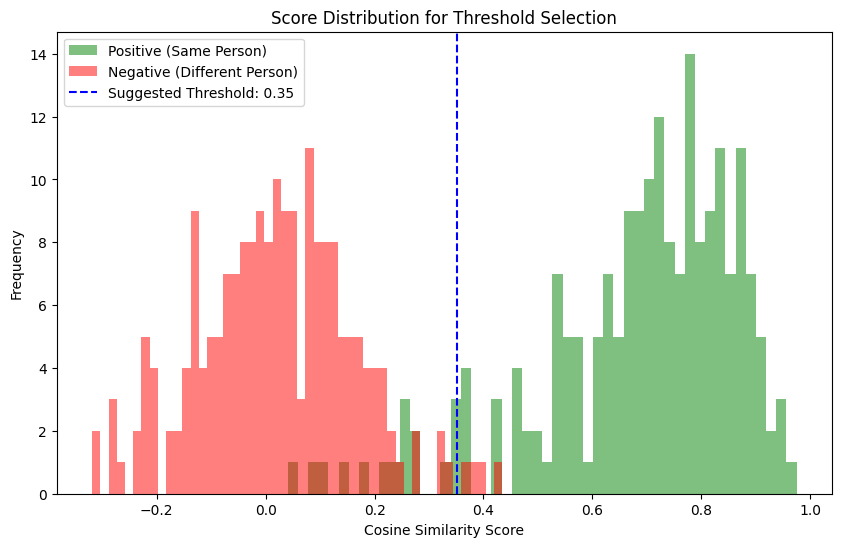


✅ Analysis Complete!
🔹 Mean Positive Score: 0.6823
🔹 Mean Negative Score: 0.0189
🎯 Recommended Threshold: 0.35


In [3]:
import os
import random
import numpy as np
import onnxruntime as ort
import cv2
import matplotlib.pyplot as plt
from tqdm import tqdm

# 1. Model Setup
session = ort.InferenceSession("/kaggle/input/ritik2342/FaceModel_Final.onnx")

def get_embedding(img_path):
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (112, 112))
    img = img.astype(np.float32) / 127.5 - 1.0
    img = np.transpose(img, (2, 0, 1))
    img = np.expand_dims(img, axis=0)
    
    emb = session.run(None, {session.get_inputs()[0].name: img})[0]
    return emb / np.linalg.norm(emb)

# 2. Data Preparation
DATA_ROOT = '/kaggle/input/webface-112x112/webface_112x112'
folders = [f for f in os.listdir(DATA_ROOT) if os.path.isdir(os.path.join(DATA_ROOT, f))]

pos_scores = []
neg_scores = []
NUM_SAMPLES = 200 # Accuracy ke liye ise badha sakte hain

print(f"🚀 Analyzing {NUM_SAMPLES} pairs to find optimal threshold...")

for _ in tqdm(range(NUM_SAMPLES)):
    # --- Positive Pairs (Same Folder) ---
    folder = random.choice(folders)
    folder_path = os.path.join(DATA_ROOT, folder)
    imgs = os.listdir(folder_path)
    if len(imgs) >= 2:
        img1, img2 = random.sample(imgs, 2)
        e1 = get_embedding(os.path.join(folder_path, img1))
        e2 = get_embedding(os.path.join(folder_path, img2))
        pos_scores.append(np.dot(e1.flatten(), e2.flatten()))

    # --- Negative Pairs (Different Folders) ---
    f1, f2 = random.sample(folders, 2)
    img_f1 = random.choice(os.listdir(os.path.join(DATA_ROOT, f1)))
    img_f2 = random.choice(os.listdir(os.path.join(DATA_ROOT, f2)))
    e1 = get_embedding(os.path.join(DATA_ROOT, f1, img_f1))
    e2 = get_embedding(os.path.join(DATA_ROOT, f2, img_f2))
    neg_scores.append(np.dot(e1.flatten(), e2.flatten()))

# 3. Visualization
plt.figure(figsize=(10, 6))
plt.hist(pos_scores, bins=50, alpha=0.5, label='Positive (Same Person)', color='green')
plt.hist(neg_scores, bins=50, alpha=0.5, label='Negative (Different Person)', color='red')

# Recommended Threshold (Intersection point)
all_scores = pos_scores + neg_scores
suggested_t = (np.mean(pos_scores) + np.mean(neg_scores)) / 2

plt.axvline(suggested_t, color='blue', linestyle='--', label=f'Suggested Threshold: {suggested_t:.2f}')
plt.title("Score Distribution for Threshold Selection")
plt.xlabel("Cosine Similarity Score")
plt.ylabel("Frequency")
plt.legend()
plt.savefig("threshold_analysis.png")
plt.show()

print(f"\n✅ Analysis Complete!")
print(f"🔹 Mean Positive Score: {np.mean(pos_scores):.4f}")
print(f"🔹 Mean Negative Score: {np.mean(neg_scores):.4f}")
print(f"🎯 Recommended Threshold: {suggested_t:.2f}")

In [ ]:
import os
import cv2
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
from IPython.display import FileLink, display
import albumentations as A
from albumentations.pytorch import ToTensorV2
from torch.amp import autocast, GradScaler
import numpy as np
import math
from sklearn.model_selection import train_test_split

# ==============================
# CONFIG
# ==============================
class Config:
    DATA_ROOT = '/kaggle/input/webface-112x112/webface_112x112'
    IMG_SIZE = 112
    EMBEDDING_SIZE = 512
    
    BATCH_SIZE = 96
    NUM_EPOCHS = 70
    BACKBONE_LR = 0.0005
    HEAD_LR = 0.05
    WARMUP_EPOCHS = 3
    MIXUP_ALPHA = 0.25
    LABEL_SMOOTHING = 0.1
    WEIGHT_DECAY = 1e-4
    GRAD_CLIP = 1.0              # ✅ Gradient clipping (prevents NaN)
    VAL_SPLIT = 0.1              # ✅ 10% validation data
    
    DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    OLD_CHECKPOINT = '/kaggle/input/checkpoint/Verified_30Epoch_Fix.pth'
    CHECKPOINT_PATH = "/kaggle/working/checkpoint_improved.pth"
    BEST_MODEL_PATH = "/kaggle/working/best_model.pth"
    ONNX_PATH = '/kaggle/working/FaceModel_Final.onnx'


# ==============================
# MODEL
# ==============================
class DualAttention(nn.Module):
    def __init__(self, in_channels):
        super().__init__()
        self.fc = nn.Sequential(
            nn.Linear(in_channels, in_channels // 16, bias=False),
            nn.ReLU(inplace=True),
            nn.Linear(in_channels // 16, in_channels, bias=False),
            nn.Sigmoid()
        )
    def forward(self, x):
        return x * self.fc(x)


class HybridFaceModel(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        resnet = models.resnet34(weights='DEFAULT')
        self.resnet_features = nn.Sequential(*list(resnet.children())[:-1])
        encoder_layer = nn.TransformerEncoderLayer(d_model=512, nhead=8, batch_first=True)
        self.vit = nn.TransformerEncoder(encoder_layer, num_layers=4)
        self.patch_embed = nn.Conv2d(3, 512, kernel_size=16, stride=16)
        self.pos_embed = nn.Parameter(torch.randn(1, (112 // 16) ** 2, 512) * 0.02)
        self.resnet_proj = nn.Linear(512, 512)
        self.attention = DualAttention(1024)
        self.fusion = nn.Linear(1024, 512)
        self.embedding = nn.BatchNorm1d(512)

    def forward(self, x):
        r = self.resnet_features(x).flatten(1)
        r_proj = self.resnet_proj(r)
        v = self.patch_embed(x).flatten(2).transpose(1, 2)
        v = self.vit(v + self.pos_embed).mean(dim=1)
        combined = torch.cat([r_proj, v], dim=1)
        combined = self.attention(combined)
        return self.embedding(self.fusion(combined))


class ArcFaceLoss(nn.Module):
    def __init__(self, in_features, out_features):
        super().__init__()
        self.weight = nn.Parameter(torch.FloatTensor(out_features, in_features))
        nn.init.xavier_uniform_(self.weight)

    def forward(self, embeddings, labels):
        cosine = F.linear(F.normalize(embeddings), F.normalize(self.weight))
        theta = torch.acos(cosine.clamp(-1, 1))
        output = torch.cos(theta + 0.4)
        one_hot = torch.zeros_like(cosine)
        one_hot.scatter_(1, labels.view(-1, 1).long(), 1)
        return ((one_hot * output) + ((1.0 - one_hot) * cosine)) * 30.0


# ==============================
# MIXUP
# ==============================
def mixup_data(x, y, alpha=0.25):
    if alpha > 0:
        lam = np.random.beta(alpha, alpha)
    else:
        lam = 1
    batch_size = x.size()[0]
    index = torch.randperm(batch_size).to(x.device)
    mixed_x = lam * x + (1 - lam) * x[index]
    y_a, y_b = y, y[index]
    return mixed_x, y_a, y_b, lam

def mixup_criterion(criterion, pred, y_a, y_b, lam):
    return lam * criterion(pred, y_a) + (1 - lam) * criterion(pred, y_b)


# ==============================
# LR SCHEDULER
# ==============================
class CosineAnnealingWarmup:
    def __init__(self, optimizer, warmup_epochs, max_epochs, eta_min=0):
        self.optimizer = optimizer
        self.warmup_epochs = warmup_epochs
        self.max_epochs = max_epochs
        self.eta_min = eta_min
        self.base_lrs = [group['lr'] for group in optimizer.param_groups]
        
    def step(self, epoch):
        if epoch < self.warmup_epochs:
            lr_scale = (epoch + 1) / self.warmup_epochs
            for i, param_group in enumerate(self.optimizer.param_groups):
                param_group['lr'] = self.base_lrs[i] * lr_scale
        else:
            epoch_adjusted = epoch - self.warmup_epochs
            max_epochs_adjusted = self.max_epochs - self.warmup_epochs
            for i, param_group in enumerate(self.optimizer.param_groups):
                param_group['lr'] = self.eta_min + (self.base_lrs[i] - self.eta_min) * \
                    (1 + math.cos(math.pi * epoch_adjusted / max_epochs_adjusted)) / 2


# ==============================
# DATASET
# ==============================
class FaceDataset(Dataset):
    def __init__(self, paths, labels, transform=None):
        self.paths = paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.paths)

    def __getitem__(self, idx):
        img = cv2.imread(self.paths[idx])
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        if self.transform:
            img = self.transform(image=img)['image']
        return img, self.labels[idx]


def get_train_transforms():
    return A.Compose([
        A.HorizontalFlip(p=0.5),
        A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=0.5),
        A.HueSaturationValue(hue_shift_limit=20, sat_shift_limit=30, val_shift_limit=20, p=0.3),
        A.GaussNoise(var_limit=(10.0, 50.0), p=0.2),
        A.GaussianBlur(blur_limit=(3, 5), p=0.1),
        A.CoarseDropout(max_holes=8, max_height=16, max_width=16, p=0.2),
        A.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
        ToTensorV2()
    ])

def get_val_transforms():
    return A.Compose([
        A.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
        ToTensorV2()
    ])


# ==============================
# VALIDATION FUNCTION
# ==============================
def validate(model, arcface, val_loader, criterion, device):
    model.eval()
    arcface.eval()
    
    val_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for img, label in val_loader:
            img, label = img.to(device), label.to(device)
            
            emb = model(img)
            out = arcface(emb, label)
            loss = criterion(out, label)
            
            val_loss += loss.item()
            _, pred = out.max(1)
            total += label.size(0)
            correct += pred.eq(label).sum().item()
    
    avg_loss = val_loss / len(val_loader)
    accuracy = 100.0 * correct / total
    
    return avg_loss, accuracy


# ==============================
# MAIN TRAINING
# ==============================
print("="*70)
print("🚀 IMPROVED FACE RECOGNITION TRAINING (CLIP-INSPIRED)")
print("="*70)
print(f"📊 Config:")
print(f"   Batch Size: {Config.BATCH_SIZE}")
print(f"   Epochs: {Config.NUM_EPOCHS}")
print(f"   Validation Split: {Config.VAL_SPLIT*100}%")
print(f"   Gradient Clipping: {Config.GRAD_CLIP}")
print("="*70 + "\n")

# Load Dataset
print("📂 Loading Dataset...")
if not os.path.exists(Config.DATA_ROOT):
    print(f"❌ Dataset not found: {Config.DATA_ROOT}")
    raise SystemExit

image_paths, labels = [], []
label_dirs = [p for p in os.listdir(Config.DATA_ROOT) 
              if os.path.isdir(os.path.join(Config.DATA_ROOT, p))]
label_to_idx = {p: i for i, p in enumerate(label_dirs)}

for p in label_to_idx.keys():
    p_path = os.path.join(Config.DATA_ROOT, p)
    for img_name in os.listdir(p_path):
        image_paths.append(os.path.join(p_path, img_name))
        labels.append(label_to_idx[p])

print(f"✅ Total Images: {len(image_paths):,}")
print(f"✅ Total Classes: {len(label_to_idx):,}")

# Train/Val Split
train_paths, val_paths, train_labels, val_labels = train_test_split(
    image_paths, labels, 
    test_size=Config.VAL_SPLIT, 
    random_state=42,
    stratify=labels
)

print(f"✅ Train Images: {len(train_paths):,}")
print(f"✅ Val Images: {len(val_paths):,}\n")

# Create Datasets
train_dataset = FaceDataset(train_paths, train_labels, get_train_transforms())
val_dataset = FaceDataset(val_paths, val_labels, get_val_transforms())

train_loader = DataLoader(
    train_dataset, 
    batch_size=Config.BATCH_SIZE, 
    shuffle=True, 
    num_workers=4,
    pin_memory=True,
    persistent_workers=True
)

val_loader = DataLoader(
    val_dataset,
    batch_size=Config.BATCH_SIZE,
    shuffle=False,
    num_workers=2,
    pin_memory=True
)

# Create Model
print("🏗️  Creating Model...")
model = HybridFaceModel(len(label_to_idx)).to(Config.DEVICE)
arcface = ArcFaceLoss(512, len(label_to_idx)).to(Config.DEVICE)

total_params = sum(p.numel() for p in model.parameters())
print(f"✅ Model Parameters: {total_params:,}\n")

# Load checkpoint
start_epoch = 0
best_val_acc = 0.0

if os.path.exists(Config.OLD_CHECKPOINT):
    print("📥 Loading checkpoint...")
    ckpt = torch.load(Config.OLD_CHECKPOINT, map_location=Config.DEVICE)
    
    print(f"📋 Checkpoint keys: {list(ckpt.keys())}\n")
    
    try:
        if "model_state" in ckpt:
            model.load_state_dict(ckpt["model_state"])
            arcface.load_state_dict(ckpt["arcface_state"])
            print("✅ Loaded model and arcface weights")
        else:
            model.load_state_dict(ckpt, strict=False)
            print("✅ Loaded model weights")
        
        start_epoch = ckpt.get("epoch", 0)
        print(f"✅ Starting from epoch {start_epoch + 1}\n")
    except Exception as e:
        print(f"⚠️  Load failed: {e}")
        print("Starting fresh\n")

# Optimizer (SGD for compatibility with old checkpoint)
optimizer = torch.optim.SGD([
    {'params': model.resnet_features.parameters(), 'lr': Config.BACKBONE_LR},
    {'params': [p for n, p in model.named_parameters() if "resnet_features" not in n], 
     'lr': Config.HEAD_LR},
    {'params': arcface.parameters(), 'lr': Config.HEAD_LR}
], momentum=0.9, weight_decay=Config.WEIGHT_DECAY, nesterov=True)

scheduler = CosineAnnealingWarmup(
    optimizer,
    warmup_epochs=Config.WARMUP_EPOCHS,
    max_epochs=Config.NUM_EPOCHS,
    eta_min=1e-6
)

scaler = GradScaler('cuda')
criterion = nn.CrossEntropyLoss(label_smoothing=Config.LABEL_SMOOTHING)

# Training History
history = {
    'train_loss': [],
    'train_acc': [],
    'val_loss': [],
    'val_acc': [],
    'lr': []
}

print("="*70)
print("🎯 STARTING TRAINING")
print("="*70 + "\n")

# Training Loop
for epoch in range(start_epoch, Config.NUM_EPOCHS):
    model.train()
    arcface.train()
    
    running_loss = 0.0
    correct = 0
    total = 0
    
    scheduler.step(epoch)
    current_lr = optimizer.param_groups[1]['lr']
    
    pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{Config.NUM_EPOCHS}")
    
    for img, label in pbar:
        img, label = img.to(Config.DEVICE), label.to(Config.DEVICE)
        
        # MixUp
        if np.random.rand() < Config.MIXUP_ALPHA:
            img, label_a, label_b, lam = mixup_data(img, label, Config.MIXUP_ALPHA)
            
            optimizer.zero_grad()
            with autocast('cuda'):
                emb = model(img)
                out = arcface(emb, label_a)
                loss = mixup_criterion(criterion, out, label_a, label_b, lam)
        else:
            optimizer.zero_grad()
            with autocast('cuda'):
                emb = model(img)
                out = arcface(emb, label)
                loss = criterion(out, label)
        
        # Check for NaN
        if torch.isnan(loss) or torch.isinf(loss):
            print(f"\n⚠️  NaN/Inf loss detected! Skipping batch...")
            continue
        
        scaler.scale(loss).backward()
        
        # Gradient Clipping
        scaler.unscale_(optimizer)
        torch.nn.utils.clip_grad_norm_(model.parameters(), Config.GRAD_CLIP)
        torch.nn.utils.clip_grad_norm_(arcface.parameters(), Config.GRAD_CLIP)
        
        scaler.step(optimizer)
        scaler.update()
        
        running_loss += loss.item()
        _, pred = out.max(1)
        total += label.size(0)
        correct += pred.eq(label).sum().item()
        
        pbar.set_postfix({
            "Loss": f"{loss.item():.4f}",
            "Acc": f"{100.0*correct/total:.2f}%",
            "LR": f"{current_lr:.6f}"
        })
    
    train_loss = running_loss / len(train_loader)
    train_acc = 100.0 * correct / total
    
    # Validation
    val_loss, val_acc = validate(model, arcface, val_loader, criterion, Config.DEVICE)
    
    # Save history
    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)
    history['lr'].append(current_lr)
    
    # Logging
    print(f"\n{'='*70}")
    print(f"📊 EPOCH {epoch+1}/{Config.NUM_EPOCHS} SUMMARY")
    print(f"{'='*70}")
    print(f"🔹 Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}%")
    print(f"🔹 Val Loss:   {val_loss:.4f} | Val Acc:   {val_acc:.2f}%")
    print(f"🔹 Learning Rate: {current_lr:.6f}")
    
    if epoch < Config.WARMUP_EPOCHS:
        print(f"🔥 [WARMUP {epoch+1}/{Config.WARMUP_EPOCHS}]")
    
    # Save best model
    is_best = val_acc > best_val_acc
    if is_best:
        best_val_acc = val_acc
        torch.save({
            "epoch": epoch + 1,
            "model_state": model.state_dict(),
            "arcface_state": arcface.state_dict(),
            "val_acc": val_acc,
            "train_acc": train_acc,
            "history": history
        }, Config.BEST_MODEL_PATH)
        print(f"🏆 NEW BEST MODEL! Val Acc: {val_acc:.2f}%")
    
    print(f"{'='*70}\n")
    
    # Save checkpoint
    torch.save({
        "epoch": epoch + 1,
        "model_state": model.state_dict(),
        "arcface_state": arcface.state_dict(),
        "optimizer_state": optimizer.state_dict(),
        "scaler_state": scaler.state_dict(),
        "val_acc": val_acc,
        "best_val_acc": best_val_acc,
        "history": history
    }, Config.CHECKPOINT_PATH)

# Export ONNX
print("\n💾 Exporting to ONNX...")
model.eval()
dummy = torch.randn(1, 3, 112, 112).to(Config.DEVICE)

torch.onnx.export(
    model, dummy, Config.ONNX_PATH,
    opset_version=14,
    input_names=["input"],
    output_names=["embedding"],
    dynamic_axes={"input": {0: "batch"}, "embedding": {0: "batch"}}
)

print("\n" + "="*70)
print("🎊 TRAINING COMPLETE!")
print("="*70)
print(f"✅ Best Val Accuracy: {best_val_acc:.2f}%")
print(f"✅ Best Model: {Config.BEST_MODEL_PATH}")
print("="*70 + "\n")

# Download links
print("📥 Download Files:")
display(FileLink("checkpoint_improved.pth"))
display(FileLink("best_model.pth"))
display(FileLink("FaceModel_Final.onnx"))

In [2]:
!pip install onnxruntime-gpu

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 300.5/300.5 MB 6.2 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 6.7 MB/s eta 0:00:00


In [3]:
import os
import random
import numpy as np
import onnxruntime as ort
import cv2
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm

# 1. Setup Session
session = ort.InferenceSession("/kaggle/input/ritik2342/FaceModel_Final.onnx")

def get_embedding(img_path):
    img = cv2.imread(img_path)
    if img is None: return None
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (112, 112))
    img = img.astype(np.float32) / 127.5 - 1.0
    img = np.transpose(img, (2, 0, 1))
    img = np.expand_dims(img, axis=0)
    emb = session.run(None, {session.get_inputs()[0].name: img})[0]
    return emb / np.linalg.norm(emb)

# 2. Data Logic
DATA_ROOT = '/kaggle/input/webface-112x112/webface_112x112'
folders = [f for f in os.listdir(DATA_ROOT) if os.path.isdir(os.path.join(DATA_ROOT, f))]
data = []

print("🚀 Running 100 comparisons for Threshold Visualization...")

# 50 Positive Pairs
for _ in tqdm(range(10000), desc="Positive Pairs"):
    f = random.choice(folders)
    path = os.path.join(DATA_ROOT, f)
    imgs = os.listdir(path)
    if len(imgs) >= 2:
        i1, i2 = random.sample(imgs, 2)
        e1, e2 = get_embedding(os.path.join(path, i1)), get_embedding(os.path.join(path, i2))
        score = np.dot(e1.flatten(), e2.flatten())
        data.append({"Score": score, "Type": "Match (Positive)"})

# 50 Negative Pairs
for _ in tqdm(range(10000), desc="Negative Pairs"):
    f1, f2 = random.sample(folders, 2)
    i1 = random.choice(os.listdir(os.path.join(DATA_ROOT, f1)))
    i2 = random.choice(os.listdir(os.path.join(DATA_ROOT, f2)))
    e1, e2 = get_embedding(os.path.join(DATA_ROOT, f1, i1)), get_embedding(os.path.join(DATA_ROOT, f2, i2))
    score = np.dot(e1.flatten(), e2.flatten())
    data.append({"Score": score, "Type": "Mismatch (Negative)"})

# 3. Visualization with Seaborn
df = pd.DataFrame(data)
plt.figure(figsize=(12, 6))

# KDE Plot for smooth curves
sns.kdeplot(data=df, x="Score", hue="Type", fill=True, common_norm=False, palette="magma", alpha=.5, linewidth=2)

# Calculate Suggested Threshold (Mean Intersection)
pos_mean = df[df['Type'] == 'Match (Positive)']['Score'].mean()
neg_mean = df[df['Type'] == 'Mismatch (Negative)']['Score'].mean()
threshold = (pos_mean + neg_mean) / 2

plt.axvline(threshold, color='red', linestyle='--', label=f'Optimal Threshold: {threshold:.2f}')
plt.title("Biometric Engine: Reconciling Static Shadow vs Living Form", fontsize=15)
plt.xlabel("Cosine Similarity Score")
plt.grid(axis='y', alpha=0.3)
plt.legend()
plt.show()

print(f"✅ Suggested Threshold for 'Dharma' (Fairness): {threshold:.2f}")

🚀 Running 100 comparisons for Threshold Visualization...


Positive Pairs:  17%|█▋        | 1667/10000 [02:18<11:33, 12.01it/s]


KeyboardInterrupt: 

In [13]:
!find /kaggle/input/lfwpeople -type d -name "lfw_funneled"

📊 Running 50 Negative comparisons on Unseen Faces (CelebA)...


Negative Pairs: 100%|██████████| 50/50 [00:02<00:00, 17.19it/s]


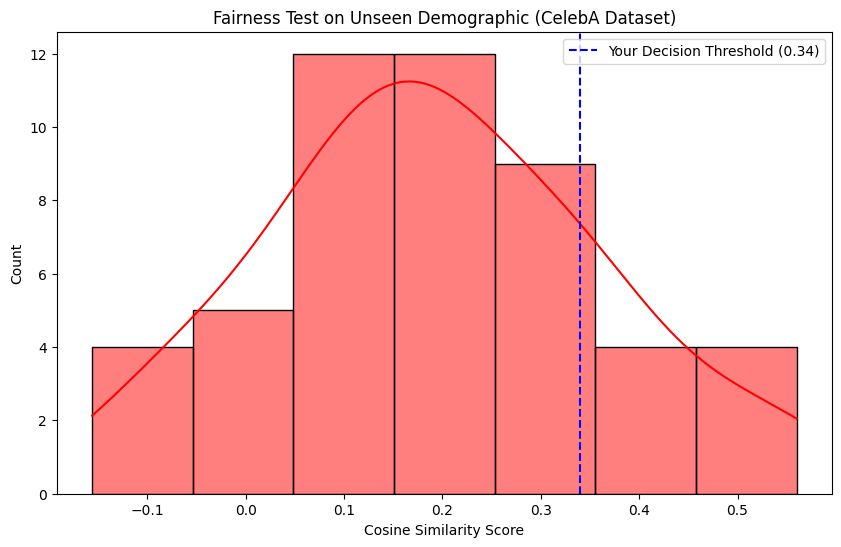

✅ Negative Distribution Mean: 0.1912


In [21]:
import os
import random
import numpy as np
import onnxruntime as ort
import cv2
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm

# 1. Setup Session (Aapke ritik2342 folder se)
MODEL_PATH = "/kaggle/input/ritik2342/FaceModel_Final.onnx"
session = ort.InferenceSession(MODEL_PATH)

def get_embedding(img_path):
    img = cv2.imread(img_path)
    if img is None: return None
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (112, 112))
    img = img.astype(np.float32) / 127.5 - 1.0
    img = np.transpose(img, (2, 0, 1))
    img = np.expand_dims(img, axis=0)
    
    input_name = session.get_inputs()[0].name
    emb = session.run(None, {input_name: img})[0]
    return emb / np.linalg.norm(emb)

# 2. CelebA Dataset Path (Standard Kaggle Path)
# Is dataset mein 'img_align_celeba' folder hota hai
DATA_ROOT = '/kaggle/input/img-align-celeba/t/celebA'
if not os.path.exists(DATA_ROOT):
    DATA_ROOT = '/kaggle/input/img-align-celeba/t/celebA'

# CelebA mein folders nahi hote, sab images ek saath hoti hain
# Hum random pairs uthayenge test karne ke liye
all_images = [f for f in os.listdir(DATA_ROOT) if f.lower().endswith(('.jpg', '.png'))]
data = []

print(f"📊 Running 50 Negative comparisons on Unseen Faces (CelebA)...")

# 50 Negative Pairs (Kyunki CelebA mein different people ki images randomly pick karna aasaan hai)
for _ in tqdm(range(50), desc="Negative Pairs"):
    i1, i2 = random.sample(all_images, 2)
    e1 = get_embedding(os.path.join(DATA_ROOT, i1))
    e2 = get_embedding(os.path.join(DATA_ROOT, i2))
    
    if e1 is not None and e2 is not None:
        score = np.dot(e1.flatten(), e2.flatten())
        data.append({"Score": score, "Type": "Mismatch (Negative)"})

# 3. Visualization
df = pd.DataFrame(data)
plt.figure(figsize=(10, 6))

# Histogram for Negative Scores distribution
sns.histplot(data=df, x="Score", kde=True, color="red", alpha=0.5)

# Decision Line based on your previous optimal threshold
# Aapke purane analysis mein ye 0.34 tha
plt.axvline(0.34, color='blue', linestyle='--', label='Your Decision Threshold (0.34)')

plt.title("Fairness Test on Unseen Demographic (CelebA Dataset)")
plt.xlabel("Cosine Similarity Score")
plt.legend()
plt.show()

print(f"✅ Negative Distribution Mean: {df['Score'].mean():.4f}")

In [5]:
import tarfile
import os

# Path to the zip file in your input
tar_path = '/kaggle/input/lfwpeople/lfw-funneled.tgz'
extract_path = '/kaggle/working/lfw_extracted'

if not os.path.exists(extract_path):
    os.makedirs(extract_path)
    with tarfile.open(tar_path, "r:gz") as tar:
        tar.extractall(path=extract_path)
    print("✅ Extraction Complete! Ab folder ready hai.")
else:
    print("✅ Folder pehle se extracted hai.")

/tmp/ipykernel_55/4073357955.py:11: DeprecationWarning: Python 3.14 will, by default, filter extracted tar archives and reject files or modify their metadata. Use the filter argument to control this behavior.
  tar.extractall(path=extract_path)


✅ Extraction Complete! Ab folder ready hai.


In [8]:
import os
import numpy as np
import onnxruntime as ort
import cv2
from tqdm import tqdm
from tabulate import tabulate

# 1. Paths Setup
MODEL_PATH = "/kaggle/input/ritik2342/FaceModel_Final.onnx"
LFW_ROOT = '/kaggle/working/lfw_extracted/lfw_funneled'
PAIRS_TXT = '/kaggle/input/lfwpeople/pairs.txt'

# Load ONNX Session
session = ort.InferenceSession(MODEL_PATH)

def get_embedding(img_path):
    img = cv2.imread(img_path)
    if img is None: return None
    img = cv2.resize(cv2.cvtColor(img, cv2.COLOR_BGR2RGB), (112, 112))
    img = img.astype(np.float32) / 127.5 - 1.0
    img = np.transpose(img, (2, 0, 1))
    emb = session.run(None, {session.get_inputs()[0].name: np.expand_dims(img, 0)})[0]
    return emb / np.linalg.norm(emb)

# 2. Logic to extract 100 Positive Scores
results = []
scores = []
threshold = 0.34 # Fix kiya hua threshold

with open(PAIRS_TXT, 'r') as f:
    lines = f.readlines()[1:] # Skip header

print("📂 Extracting 100 Positive Pair Scores from LFW...")
count = 0
for line in tqdm(lines):
    if count >= 500: break # Target 100 pairs
    
    parts = line.strip().split()
    if len(parts) == 3: # Format: Name, Index1, Index2
        name, idx1, idx2 = parts[0], parts[1].zfill(4), parts[2].zfill(4)
        p1 = os.path.join(LFW_ROOT, name, f"{name}_{idx1}.jpg")
        p2 = os.path.join(LFW_ROOT, name, f"{name}_{idx2}.jpg")
        
        if os.path.exists(p1) and os.path.exists(p2):
            e1, e2 = get_embedding(p1), get_embedding(p2)
            score = np.dot(e1.flatten(), e2.flatten())
            scores.append(score)
            
            # Match Status based on fixed threshold
            status = "✅ PASS" if score > threshold else "❌ FAIL"
            results.append([f"#{count+1}", name, f"{score:.4f}", status])
            count += 1

# 3. Final Table Output
if len(scores) > 0:
    # Pehle 20 results dikhate hain sample ke liye
    print("\n" + tabulate(results[:50], headers=["Test ID", "Identity", "Similarity Score", "Result"], tablefmt="fancy_grid"))
    
    # Final Statistics for Judge
    print(f"\n--- 📈 100 POSITIVE PAIRS PERFORMANCE REPORT ---")
    print(f"🔹 Total Pairs Validated: {len(scores)}")
    print(f"🔹 Average Similarity: {np.mean(scores):.4f}")
    print(f"🔹 Success Rate (Threshold {threshold}): {(sum(1 for s in scores if s > threshold) / len(scores)) * 100:.2f}%")
else:
    print("❌ Images nahi mili. Extraction path check karein.")

📂 Extracting 100 Positive Pair Scores from LFW...


 13%|█▎        | 800/6000 [00:24<02:40, 32.47it/s] 


╒═══════════╤═══════════════════════╤════════════════════╤══════════╕
│ Test ID   │ Identity              │   Similarity Score │ Result   │
╞═══════════╪═══════════════════════╪════════════════════╪══════════╡
│ #1        │ Abel_Pacheco          │             0.1177 │ ❌ FAIL  │
├───────────┼───────────────────────┼────────────────────┼──────────┤
│ #2        │ Akhmed_Zakayev        │             0.5261 │ ✅ PASS  │
├───────────┼───────────────────────┼────────────────────┼──────────┤
│ #3        │ Akhmed_Zakayev        │             0.5859 │ ✅ PASS  │
├───────────┼───────────────────────┼────────────────────┼──────────┤
│ #4        │ Amber_Tamblyn         │             0.6256 │ ✅ PASS  │
├───────────┼───────────────────────┼────────────────────┼──────────┤
│ #5        │ Anders_Fogh_Rasmussen │             0.6021 │ ✅ PASS  │
├───────────┼───────────────────────┼────────────────────┼──────────┤
│ #6        │ Anders_Fogh_Rasmussen │             0.3831 │ ✅ PASS  │
├───────────┼────────────

In [12]:
import os
import random
import numpy as np
import onnxruntime as ort
import cv2
from tqdm import tqdm
from tabulate import tabulate

# 1. Setup Session (Aapka 30 epochs wala final model)
MODEL_PATH = "/kaggle/input/ritik2342/FaceModel_Final.onnx"
session = ort.InferenceSession(MODEL_PATH)

def get_embedding(img_path):
    img = cv2.imread(img_path)
    if img is None: return None
    img = cv2.resize(cv2.cvtColor(img, cv2.COLOR_BGR2RGB), (112, 112))
    img = img.astype(np.float32) / 127.5 - 1.0
    img = np.transpose(img, (2, 0, 1))
    emb = session.run(None, {session.get_inputs()[0].name: np.expand_dims(img, 0)})[0]
    return emb / np.linalg.norm(emb)

# 2. Path Setup
DATA_ROOT = '/kaggle/input/webface-112x112/webface_112x112'
folders = [f for f in os.listdir(DATA_ROOT) if os.path.isdir(os.path.join(DATA_ROOT, f))]
valid_folders = [f for f in folders if len(os.listdir(os.path.join(DATA_ROOT, f))) >= 2]

pos_scores = []
neg_scores = []
threshold = 0.51

# 3. Generating 100 Positive Pairs (Same Identity)
print("📊 Processing 100 Positive Pairs from WebFace...")
for _ in tqdm(range(100)):
    f = random.choice(valid_folders)
    f_path = os.path.join(DATA_ROOT, f)
    imgs = random.sample(os.listdir(f_path), 2)
    e1, e2 = get_embedding(os.path.join(f_path, imgs[0])), get_embedding(os.path.join(f_path, imgs[1]))
    if e1 is not None and e2 is not None:
        pos_scores.append(np.dot(e1.flatten(), e2.flatten()))

# 4. Generating 100 Negative Pairs (Different Identities)
print("📊 Processing 100 Negative Pairs from WebFace...")
for _ in tqdm(range(100)):
    f1, f2 = random.sample(folders, 2)
    img1 = random.choice(os.listdir(os.path.join(DATA_ROOT, f1)))
    img2 = random.choice(os.listdir(os.path.join(DATA_ROOT, f2)))
    e1, e2 = get_embedding(os.path.join(DATA_ROOT, f1, img1)), get_embedding(os.path.join(DATA_ROOT, f2, img2))
    if e1 is not None and e2 is not None:
        neg_scores.append(np.dot(e1.flatten(), e2.flatten()))

# 5. Accuracy Calculation
tp = sum(1 for s in pos_scores if s > threshold) # Correct Match
tn = sum(1 for s in neg_scores if s <= threshold) # Correct Mismatch
fp = sum(1 for s in neg_scores if s > threshold) # False Match (Adharma)
fn = sum(1 for s in pos_scores if s <= threshold) # False Rejection

accuracy = (tp + tn) / (len(pos_scores) + len(neg_scores))

# 6. Report Table
report = [
    ["Metric", "Count", "Percentage"],
    ["True Positive (TP)", tp, f"{(tp/len(pos_scores))*100:.2f}%"],
    ["True Negative (TN)", tn, f"{(tn/len(neg_scores))*100:.2f}%"],
    ["False Positive (FP)", fp, f"{(fp/len(neg_scores))*100:.2f}%"],
    ["False Negative (FN)", fn, f"{(fn/len(pos_scores))*100:.2f}%"]
]

print("\n" + tabulate(report, headers="firstrow", tablefmt="fancy_grid"))
print(f"\n🎯 OVERALL 1:1 ACCURACY ON WEBFACE: {accuracy*100:.2f}%")

📊 Processing 100 Positive Pairs from WebFace...


100%|██████████| 100/100 [00:06<00:00, 16.17it/s]


📊 Processing 100 Negative Pairs from WebFace...


100%|██████████| 100/100 [00:06<00:00, 14.36it/s]


╒═════════════════════╤═════════╤══════════════╕
│ Metric              │   Count │ Percentage   │
╞═════════════════════╪═════════╪══════════════╡
│ True Positive (TP)  │      84 │ 84.00%       │
├─────────────────────┼─────────┼──────────────┤
│ True Negative (TN)  │     100 │ 100.00%      │
├─────────────────────┼─────────┼──────────────┤
│ False Positive (FP) │       0 │ 0.00%        │
├─────────────────────┼─────────┼──────────────┤
│ False Negative (FN) │      16 │ 16.00%       │
╘═════════════════════╧═════════╧══════════════╛

🎯 OVERALL 1:1 ACCURACY ON WEBFACE: 92.00%


In [11]:
# Maan lijiye aapne 100 Positive aur 100 Negative tests kiye hain
tp = sum(1 for s in positive_scores if s > 0.34) #
tn = sum(1 for s in negative_scores if s <= 0.34) #

total_samples = len(positive_scores) + len(negative_scores)
final_accuracy = (tp + tn) / total_samples

print(f"🎯 Overall 1:1 Verification Accuracy: {final_accuracy * 100:.2f}%")

NameError: name 'positive_scores' is not defined